## Chapter 14: Tree-based learners

# 14.3 Regression Trees

You can toggle the code on and off in this presentation via the button below.

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In this Section we discuss the use of tree-based units for the problem of regression, often called *regression trees*.  Unlike kernel or neural network universal approximators, cost functions imbued with tree-based units create highly non-convex and often flat staircase-like cost functions that cannot be optimized directly via any local method.  Instead, trees must be fit to regression (and classification) data *recursively* in a heuristic manner.

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import autograd.numpy as np
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'
 
# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# plotting
import matplotlib.pyplot as plt
import copy

%load_ext autoreload
%autoreload 2

##  Regression Stumps

- Tuning the parameters of a stump-based model by minimizing an appropiate cost function (e.g., the Least Squares) is generally very difficult.

- Not only is such a cost function non-convex, but it consists of staircase-like sections containing completely flat regions that no local optimization algorithm can navigate effectively. 

- The problematic parameter producing this effect is always the *split-point*, regardless of how the leaf values are set. 

We illustrate this via a simple example where:

(top left) by visualizing *three one-dimensional slices* of the full three-dimensional Least Squares cost function over this dataset and the split-point parameter alone, each slice provided by a stump with distinct *fixed leaf values* (the stumps are plotted in the top-right panel of the Figure).  With the leaf values of each stump fixed only the split-point parameter of each stump remains to be optimally tuned, and hence its Least Squares cost is *one-dimensional*.  In other words, we take each stump shown in the top-right panel of the Figure and sweep it over the dataset horizontally, trying out all possible split-points for each in the input space of the dataset, and plot the corresponding cost functions.  These costs are plotted in the middle-left panel of the Figure, and are colored to match their corresponding stumps shown in the top-right panel (e.g., the red cost corresponds to the red stump, the blue cost the blue stump, and the green cost the green stump).  Each cost, as we can see, looks like a staircase consisting of perfectly flat regions. 

### Determining proper split-points

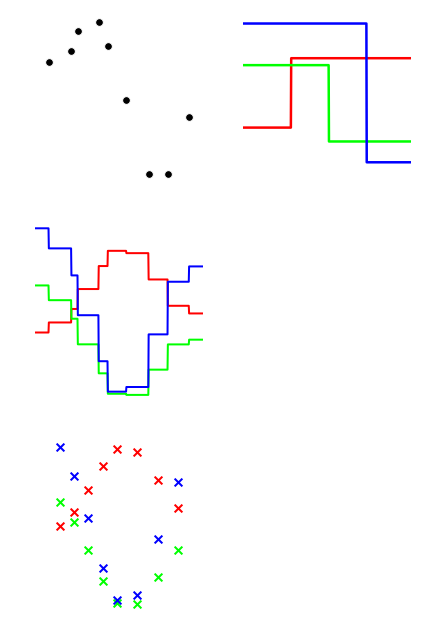

In [2]:
## This code cell will not be shown in the HTML version of this notebook
csvname = datapath + 'noisy_sin_subsample_2.csv'
demo = nonlib.regression_tree_demo.Visualizer(csvname)
demo.multistump_plotter()

- However, all is not lost! Note that, when the leaf values are fixed the corresponding Least Squares cost *stays at the exact same level when the split-point lies in-between the input of any two datapoints*.

- This means that - regardless of the values of a stump's leaves - its corresponding cost value will always *remain constant for split-point values in-between consecutive inputs*.  

- This fact has a very practical repercussion: we can always very easily find one candidate split-point per flat region since we need only take a point in-between each successive pair of inputs of our dataset, e.g., the *midpoint*.

### Determining optimal leaf values for a fixed split-point

- Since the leaves are *constant valued*, and we are using the stump as a nonlinear regressor, it makes intuitive sense to simply set the value of each leaf *to the mean of the points it will represent*. 

- Indeed these intuitive choices for leaf values can be determined mechanically by minimizing the Least Squares cost employing a single stump model with fixed split-point.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


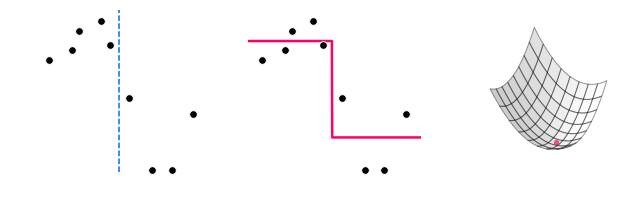

In [3]:
## This code cell will not be shown in the HTML version of this notebook
csvname = datapath + 'noisy_sin_subsample_2.csv'
demo = nonlib.regression_tree_demo.Visualizer(csvname)
demo.best_plotter()

Algebraically speaking, in general can set the leaf values of a stump $f$ with split-point $s$ defined along $n^{th}$ dimension of a dataset of $P$ points' input as

\begin{equation}
f\left(\mathbf{x}\right) = 
\begin{cases}
\frac{1}{\vert \Omega_L \vert }\sum_{p \in \Omega_L}x_{p,n}    \,\,\,\,\,\, \text{if} \,\,\,\,\, x_n \leq s \\
\frac{1}{\vert \Omega_R \vert}\sum_{p \in \Omega_R}x_{p,n} \,\,\,\,\,\, \text{if} \,\,\,\,\,  x_n > s
\end{cases}
\end{equation}

where $\Omega_L$ and $\Omega_R$ are index sets containing those points from the training set whose $n^{th}$ dimension is less than / equal to or greater than the split point value respectively in other words

\begin{array}
\
\Omega_L = \left\{\mathbf{x})_p \vert x_{p,n} \leq s  \right\} \\
\Omega_R = \left\{\mathbf{x})_p \vert x_{p,n} > s  \right\}. \\
\end{array}

### Determining optimal split-point and leaf values

Combining the two previous ideas provides a reasonable work-around way for tuning all three parameters of a stump to a regression dataset:

- We first create a set of candidate split-point values by recording every mid-point between our input data, along each of its dimensions.

- For each candidate split-point we determine the optimal stump, whose leaf values are set to the average of the training data output to the left and right of the split, and compute its (Least Squares) cost value.

- Doing this for all candidate split points, finally we keep the one that provides the *lowest* cost value.  

This idea is illustrated in below for the simple single-input regression dataset used above.  As the slider is moved from left to right the optimal stump is fit using each midpoint as a candidate split point.  Once all candidates have been tested - when the slider mechanism is all the way to the right - the particular stump providing the lowest possible cost value is kept.  In doing this we have indeed determined the parameters of the optimal stump to represent this dataset.  More generally for multi-input such split-points are formed and tested *along each input dimension*, with the particular split / leaf values providing the lowest cost value being the optimal choice.  When computation becomes a primary concern (mainly with large datasets) subsampling strategies derived from this basic sceheme are used - like e.g., testing split-points along only a random selection of all input dimensions, testing a coarser selection of split-points, etc.,


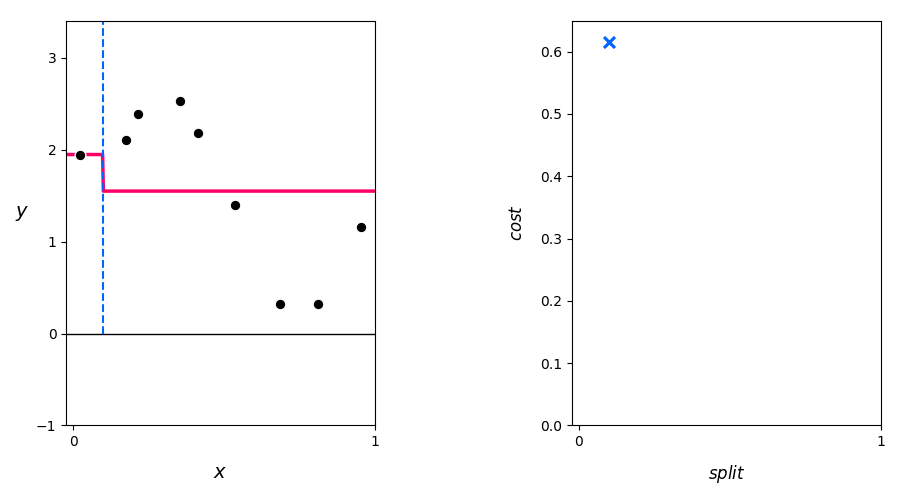
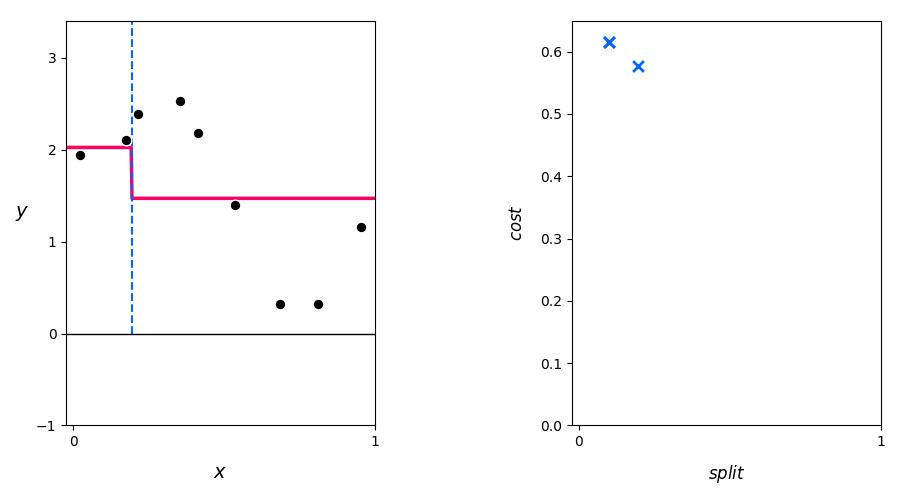
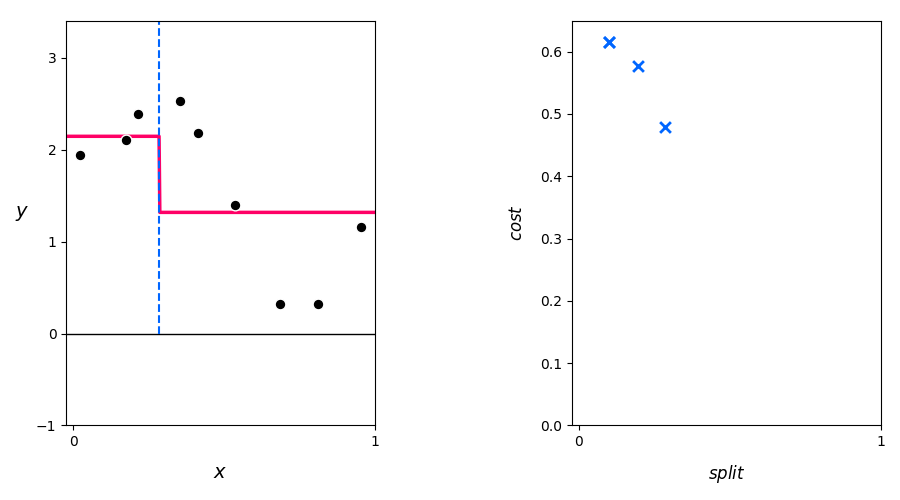
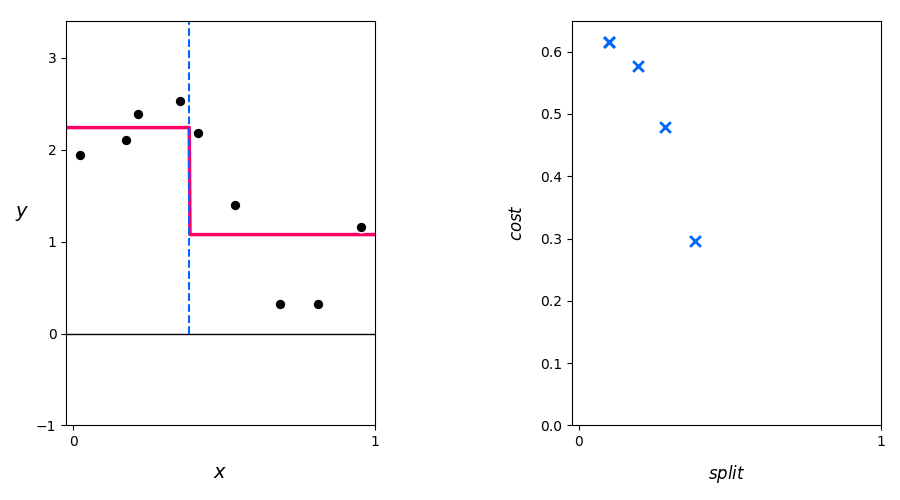
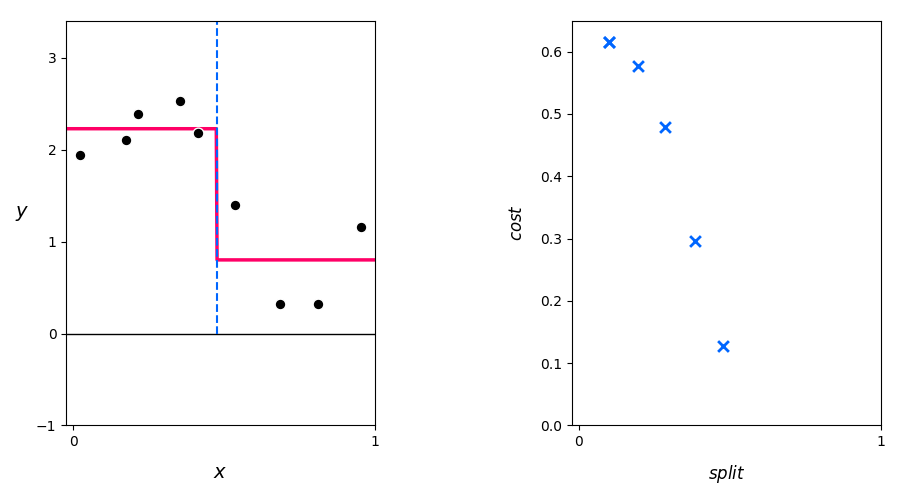
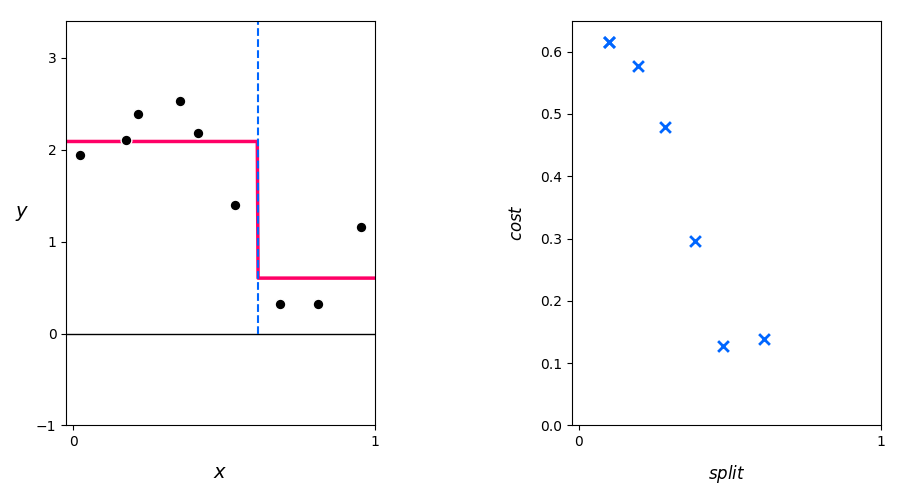
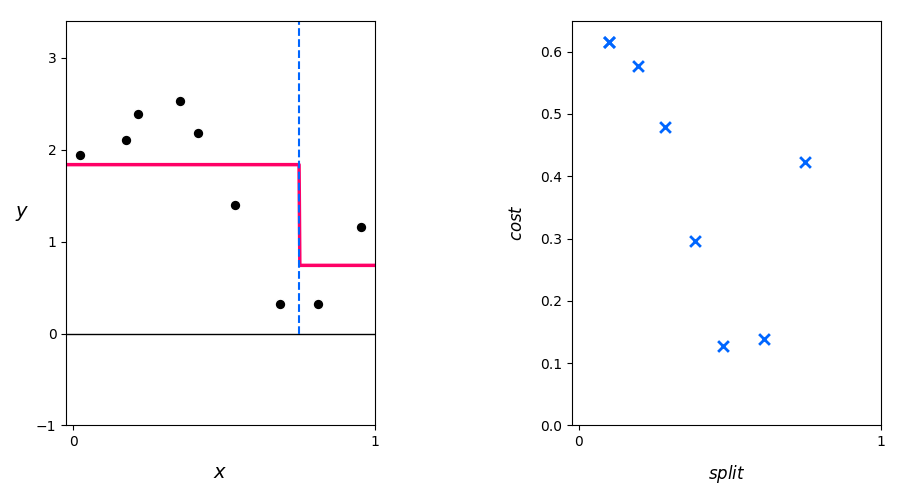
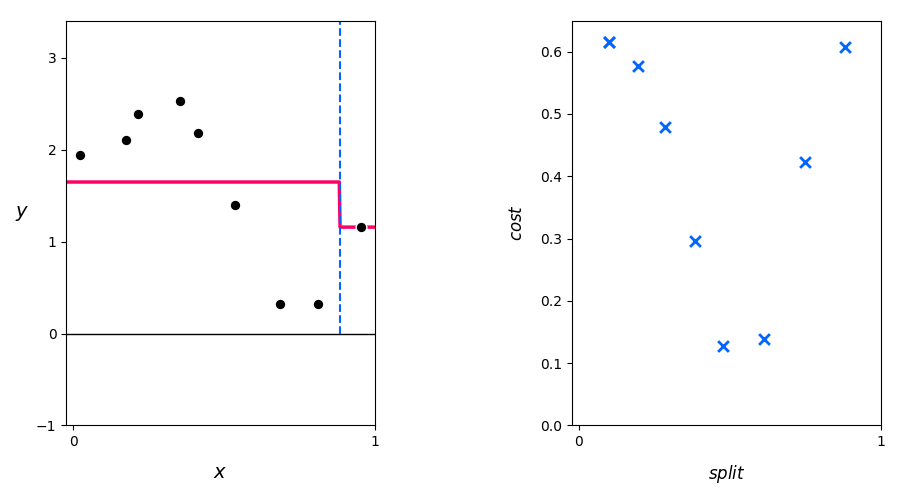

In [35]:
## This code cell will not be shown in the HTML version of this notebook
# animate stump collection for a sample dataset
demo = nonlib.stump_visualizer_2d.Visualizer()
csvname = datapath + 'noisy_sin_subsample_raised_2.csv'
demo.load_data(csvname)
demo.browse_stumps()

##  Regression Trees of Maximum Depth

- To fit a depth two binary tree to a regression dataset we can first fit a stump, and then recurse on the same idea on each of the stump's leaves. 

- We can then go on and repeat this process - splitting each leaf of our depth two tree, creating a depth three tree, and so on.

This recursive procedure is illustrated in the Figure below.  We begin (on the left) by fitting a stump to the original dataset.  As the slider is moved from left to right the recursion proceeds, with each leaf of the preceeding tree split in order to create the next depth tree.  Notice that *unlike* kernel and neural network universal approximators, tree-based units are *defined locally*.  When we adjust the parameter of e.g., a neural network unit it can globally affect the shape of the function over the entire input space.  However when we split any leaf of a tree we are only effecting the shape of the tree *locally* at that leaf.  This is why tree-based universal approximators are sometimes called *local function approximators*.


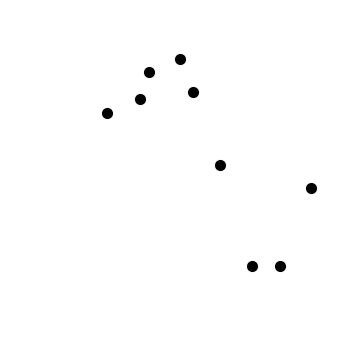
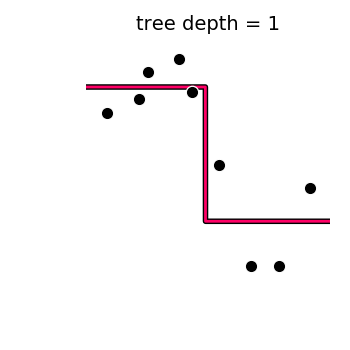
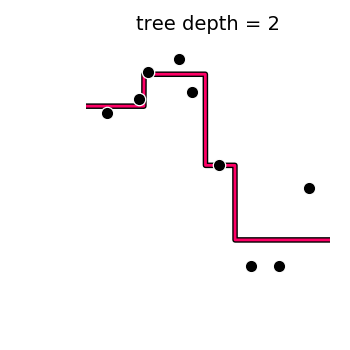
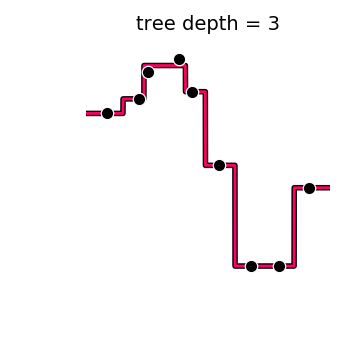
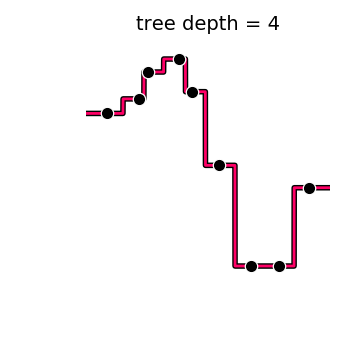
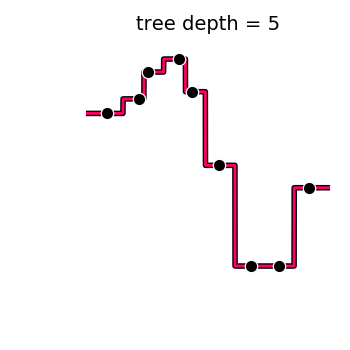

In [27]:
## This code cell will not be shown in the HTML version of this notebook
# create regression tree
csvname = datapath + 'noisy_sin_subsample_2.csv'
depth = 5
tree = nonlib.recursive_tree_lib.RegressionTree.RTree(csvname, depth)

# animate growth
demo = nonlib.recursive_tree_lib.regression_animator.Visualizer(csvname)
frames = depth
demo.animate_trees(tree)

Notice, in the recursive process of growing a binary tree *to fit regression data*:

- if any leaf ever contains just a single datapoint *we do not split the leaf containing it*.

- if all datapoints contained in the input space of a leaf *have precisely the same output value* there is again no reason to split the leaf into two distinct levels, and progress should be halted as well.

- This means that - in general - binary trees of a defined depth do not often end up 'perfect' in practice, that is where each original leaf is split exactly the same number of times. 

- Instead certain branches stemming from the root of the tree may halt sooner than others and be uneven in length, with some growing to the defined depth. 

- Thus, we refer to trees as having a *maximum depth* - the largest depth that a branch of the tree can possibly grow to. 